# Bengali Fake News Classification


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.1 MB/s eta 0:00:00


In [4]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [5]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [6]:
from sklearn.model_selection import train_test_split

auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake-1K.csv")
df = auth[:fake.shape[0]* 7]

df = df.append(fake)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])


df = train_df.append(fake.sample(len(fake)*6, replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)
train_df=df

In [7]:
len(train_df)

16107

In [8]:
df.head()

,articleID,domain,date,category,headline,content,label
0,314,motikontho.wordpress.com,2014-09-29T09:24:34+00:00,Education,"ঢাবি, আই এম ইউর ফাদার: নাহিদ | দৈনিক মতিকণ্ঠ",নিজস্ব মতিবেদকলক্ষ লক্ষ এ প্লাস পাওয়া ছেলেমেয়ে...,0
1,10824,jagonews24.com,2018-09-23 22:01:10,National,ফটোশুট ফেরত মডেলের গাড়িতে পৌনে দুই লাখ ইয়াবা!,চট্টগ্রাম-কক্সবাজার মহাসড়কের পটিয়ায় একটি প্রাই...,1
2,9104,bangla.thereport24.com,2018-09-24 14:57:20,National,"আশুরা : তাৎপর্য, করণীয় ও বর্জনীয়-দুই",মাহফূজ আল-হামিদ (পূর্ব প্রকাশের পর) আমরা আপাতত...,1
3,846,bengalbeats.com,2019-06-17T17:21:35+00:00,Miscellaneous,ন্যায্যমূল্যে সিগারেট কেনার লাইনে দাঁড়ানো নিয়ে...,কদিন ধরেই সিগারেটের বেশি দামের জন্য দেশজুড়ে বয়...,0
4,979,earki.com,"সেম্বর ১৮, ২০১৮",Miscellaneous,বিমানে চড়ার যেসব আদবকেতা মেনে না চললে বিমান আক...,বিমানে চড়াটা আমাদের অনেকের কাছেই বেশ সোজা মনে ...,0


In [9]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = train_df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
চট্টগ্রাম-কক্সবাজার মহাসড়কের পটিয়ায় একটি প্রাইভেটকারে তল্লাশি চালিয়ে পৌনে দুই লাখ পিস ইয়াবাসহ এক নারী ও দুই যুবককে আটক করেছে র‌্যাপিড অ্যাকশন ব্যাটালিয়ন (র‌্যাব)। র‌্যাবের কাছে তারা ‘মডেল’ হিসেবে দাবি করেন। ফটোশুট শেষে ঢাকায় ফিরছিলেন তারা। শনিবার রাত সাড়ে ৭টার দিকে পটিয়া উপজেলার শান্তিরহাট এলাকা থেকে তাদের আটক করা হয়। তারা হলেন- মডেল সুমাইয়া আক্তার (১৯), অভিনেতা অর্পণ দাশ (৩০) ও গাড়িচালক মো. শরীফ (৩২)। র‌্যাব-৭ এর সহকারী পরিচালক এএসপি মিমতানুর রহমান জাগো নিউজকে বলেন, ‘গোপন সংবাদের ভিত্তিতে শান্তিরহাট বাজারের কাছাকাছি চেকপোস্ট বসিয়ে একটি প্রাইভেটকারে তল্লাশি চালাই। এ সময় গাড়িতে থাকা যুবতী সুমাইয়া নিজেকে মডেল এবং অর্পণ নিজেকে অভিনেতা বলে পরিচয় দেন। তল্লাশি শেষে গাড়ি থেকে এক লাখ ৭০ হাজার পিস ইয়াবা জব্দ করা হয়।’ তিনি আরও বলেন, আটক তিনজন কক্সবাজার থেকে প্রাইভেটকারে ঢাকায় ফিরছিলেন। কক্সবাজারে যাওয়ার কারণ হিসেবে ফটোশুটের কথা বললেও মূলত তাদের উদ্দেশ্য ছিল ইয়াবা পাচার। ‘বিস্তারিত জানতে তাদের জিজ্ঞাসাবাদ চলছে’- বলেও জানান তিনি। আবু আজাদ/এমএআর/এমআরএম

********** 

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [10]:
train_df['head'] = train_df.headline.apply(clean_text)
train_df['con'] = train_df.content.apply(clean_text)
test_df['head'] = test_df.headline.apply(clean_text)
test_df['con'] = test_df.content.apply(clean_text)

from sklearn.model_selection import train_test_split

train_df, testa_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [11]:
len(df), len(test_df)

(16107, 2079)

In [12]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [13]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [14]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc5(self.dropout(x))
        
        return x

In [15]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [16]:
# for param in bert.parameters():
#     param.requires_grad = False

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [18]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[ 0.0976, -0.0415]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [19]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training

In [20]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [21]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [22]:
epochs = 10
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [23]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.354531.. 	Valid Loss:0.129607.. 	Accuracy: 97.2102
Epoch: 2/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.089076.. 	Valid Loss:0.027304.. 	Accuracy: 99.4228
Epoch: 3/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.019776.. 	Valid Loss:0.089603.. 	Accuracy: 98.4608
Epoch: 4/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.011798.. 	Valid Loss:0.054580.. 	Accuracy: 99.2304
Epoch: 5/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.009337.. 	Valid Loss:0.064460.. 	Accuracy: 98.9899
Epoch: 6/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.010190.. 	Valid Loss:0.067382.. 	Accuracy: 98.9899
Epoch: 7/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.008573.. 	Valid Loss:0.069263.. 	Accuracy: 98.9899
Epoch: 8/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.006803.. 	Valid Loss:0.070272.. 	Accuracy: 98.9899
Epoch: 9/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.007391.. 	Valid Loss:0.070241.. 	Accuracy: 98.9899
Epoch: 10/10


  0%|          | 0/1007 [00:00<?, ?it/s]

	Train loss:0.007583.. 	Valid Loss:0.070200.. 	Accuracy: 98.9899
Training completed in 71m 5s


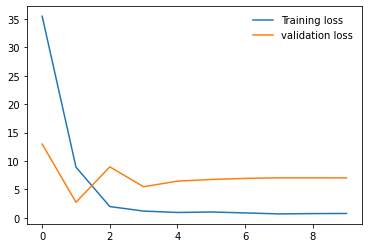

In [24]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [25]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [26]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [27]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       260
           1       1.00      1.00      1.00      1819

    accuracy                           0.99      2079
   macro avg       0.99      0.99      0.99      2079
weighted avg       0.99      0.99      0.99      2079



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।

In [28]:
 from sklearn import metrics

In [29]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)



In [30]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


In [31]:
import matplotlib.pyplot as plt



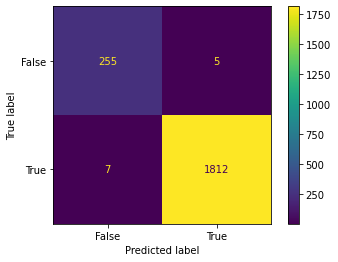

In [32]:
cm_display.plot()
plt.show()